In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_damped_pendulum_data, get_damped_SHM_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics, damped_SHM_dynamics, damped_pendulum_dynamics
from parameterised_invariance_kernels import get_polynomial_invariance, get_damped_polynomial_invariance
from damped_invariance_kernel import SHMEpsilonMean, PendulumEpsilonMean, PolynomialEpsilonMean
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

In [2]:

class SHMLatentInvariance(gpflow.kernels.Kernel):
    def __init__(self, invariance_range, invar_density, jitter_size):
        super().__init__(active_dims=[0, 1])
        self.Ka = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kv = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kz = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.jitter = jitter_size
        invariance_xs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_vs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_xx, invariance_vv = tf.meshgrid(invariance_xs, invariance_vs)
        self.invar_grids = tf.stack([tf.reshape(invariance_xx,[-1]), tf.reshape(invariance_vv,[-1])], axis=1)
        self.x_g_squared = tf.tensordot(self.invar_grids[:,0,None],self.invar_grids[None,:,0],1)
        self.x_g_dot_squared = tf.tensordot(self.invar_grids[:,1,None],self.invar_grids[None,:,1],1)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        n = X.shape[0]
        m = X2.shape[0]

        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        zeros_nm =tf.zeros((n,m), dtype=tf.float64)
        zeros_mm =tf.zeros((m,m), dtype=tf.float64)
        
        Ka_X1X1  = self.Ka(X) 
        Kv_X1X1  = self.Kv(X) 
        Kz_X1X1  = self.Kz(X) 
        K_X1X1   = tf.concat([tf.concat([Ka_X1X1,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X1X1,zeros_nn],1),tf.concat([zeros_nn,zeros_nn, Kz_X1X1],1)],0)

        Ka_X1X2  = self.Ka(X, X2) 
        Kv_X1X2  = self.Kv(X, X2) 
        Kz_X1X2  = self.Kz(X, X2) 
        K_X1X2   = tf.concat([tf.concat([Ka_X1X2,zeros_nm, zeros_nm],1),tf.concat([zeros_nm, Kv_X1X2, zeros_nm],1),tf.concat([zeros_nm, zeros_nm, Kz_X1X2],1)],0)
        
        K_X2X1   = tf.transpose(K_X1X2)
        
        Ka_X2X2  = self.Ka(X2) 
        Kv_X2X2  = self.Kv(X2) 
        Kz_X2X2  = self.Kz(X2) 
        K_X2X2   = tf.concat([tf.concat([Ka_X2X2,zeros_mm, zeros_mm],1),tf.concat([zeros_mm,Kv_X2X2, zeros_mm],1),tf.concat([zeros_mm, zeros_mm, Kz_X2X2],1)],0)
        
        Ka_X1Xg  = self.Ka(X, self.invar_grids) 
        Kv_X1Xg  = self.Kv(X, self.invar_grids) 
        Kz_X1Xg  = self.Kz(X, self.invar_grids) 
        K_X1Xg = tf.concat([Ka_X1Xg, Kv_X1Xg, Kz_X1Xg],0)

        Ka_X2Xg =  self.Ka(X2, self.invar_grids) 
        Kv_X2Xg =  self.Kv(X2, self.invar_grids)
        Kz_X2Xg  = self.Kz(X2, self.invar_grids) 
        K_X2Xg = tf.concat([Ka_X2Xg, Kv_X2Xg, Kz_X2Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g_1 = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,0]
        x_g_dot_1 = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g_1 = tf.ones([n, x_g_1.shape[1]], dtype=tf.float64) 
        x_g_1_stacked = tf.concat([x_g_dot_1, x_g_1, z_g_1],0)
        
        x_g_2 = tf.ones([m, 1], dtype=tf.float64) * self.invar_grids[:,0]
        x_g_dot_2 = tf.ones([m, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g_2 = tf.ones([m, x_g_2.shape[1]], dtype=tf.float64) 
        x_g_2_stacked = tf.concat([x_g_dot_2, x_g_2, z_g_2],0)
        
        A = tf.concat([tf.concat([K_X1X1, K_X1X2],1),tf.concat([K_X2X1, K_X2X2],1)],0) 
        B1 = tf.multiply(K_X1Xg, x_g_1_stacked)
        B2 = tf.multiply(K_X2Xg, x_g_2_stacked)
        B = tf.concat([B1, B2], 0)
        C = tf.transpose(B)
        D = tf.multiply(self.x_g_dot_squared, Ka_XgXg) + tf.multiply(self.x_g_squared, Kv_XgXg) + Kz_XgXg 
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        return (A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D), 1), C, 1))[:2*n, 3*n:(3*n+2*m)]

    def K_diag(self, X):
        n = X.shape[0]
        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        
        Ka_X  = self.Ka(X) 
        Kv_X  = self.Kv(X) 
        Kz_X  = self.Kz(X)
        K_X   = tf.concat([tf.concat([Ka_X,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X, zeros_nn],1),tf.concat([zeros_nn, zeros_nn, Kz_X],1)],0)
        
        Ka_Xg  = self.Ka(X, self.invar_grids) 
        Kv_Xg  = self.Kv(X, self.invar_grids) 
        Kz_Xg  = self.Kz(X, self.invar_grids) 
        K_Xg = tf.concat([Ka_Xg, Kv_Xg, Kz_Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,0]
        x_g_dot = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g = tf.ones([n, x_g.shape[1]],dtype=tf.float64)
        x_g_stacked = tf.concat([x_g_dot, x_g, z_g],0)
        
        A = K_X
        B = tf.multiply(K_Xg, x_g_stacked)
        C = tf.transpose(B)
        D = tf.multiply(self.x_g_dot_squared, Ka_XgXg) + tf.multiply(self.x_g_squared, Kv_XgXg) + Kz_XgXg
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        
        return tf.linalg.tensor_diag_part((A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D),1), C, 1))[:2*n,:2*n])

In [17]:

def get_latent_SHM_invariance(invar_range, invar_density, jitter_size):
    invariance_kernel = SHMLatentInvariance(invar_range, invar_density, jitter_size)
    invariance_kernel.Ka.variance = gpflow.Parameter(invariance_kernel.Ka.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.variance = gpflow.Parameter(invariance_kernel.Kv.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.variance = gpflow.Parameter(invariance_kernel.Kz.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Ka.lengthscales = gpflow.Parameter(invariance_kernel.Ka.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.lengthscales = gpflow.Parameter(invariance_kernel.Kv.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.lengthscales = gpflow.Parameter(invariance_kernel.Kz.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    return invariance_kernel

In [36]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 3
max_v = 0.3
n_train = 5
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_SHM_data(0.1, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[1.20276684 1.31078    1.22441323 0.69517751 2.0960932 ]
[ 0.07476317 -0.05513731  0.18571546 -0.11293368 -0.07262478]


In [37]:

moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 5e-5
invar_density = 40
latex=""
kernel = get_latent_SHM_invariance(3, invar_density, jitter) #switch
known = get_GPR_model(kernel, mean, data, 500)
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
i = 0
'''
for poly_f_d in [2]:
    for poly_g_d in [2]:
        kernel = get_damped_polynomial_invariance(3, invar_density, jitter, poly_f_d, poly_g_d) #switch
        m = get_GPR_model(kernel, mean, data, 3000)
        print("(%s, %s)----------------------"%(poly_f_d-1, poly_g_d-1))
        np.set_printoptions(precision=4)
#            print(kernel.f_poly.numpy())
#            print(kernel.g_poly.numpy())
        print(format(m.log_marginal_likelihood().numpy(),".2f"))
        latex+=format(m.log_marginal_likelihood().numpy(),".2f")
        i+=1
        if i%9==0:
            latex+='\\'
        else:
            latex+="&"
'''

moi:417.46
known: 434.00


'\nfor poly_f_d in [2]:\n    for poly_g_d in [2]:\n        kernel = get_damped_polynomial_invariance(3, invar_density, jitter, poly_f_d, poly_g_d) #switch\n        m = get_GPR_model(kernel, mean, data, 3000)\n        print("(%s, %s)----------------------"%(poly_f_d-1, poly_g_d-1))\n        np.set_printoptions(precision=4)\n#            print(kernel.f_poly.numpy())\n#            print(kernel.g_poly.numpy())\n        print(format(m.log_marginal_likelihood().numpy(),".2f"))\n        latex+=format(m.log_marginal_likelihood().numpy(),".2f")\n        i+=1\n        if i%9==0:\n            latex+=\'\\\'\n        else:\n            latex+="&"\n'

In [38]:

eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []

grids = (3, 40)
dynamics = damped_SHM_dynamics

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
#lml_inv_p = m.log_marginal_likelihood().numpy()

#grid_moi = (evaluate_model_grid(moi, grids, dynamics))
#grid_inv = (evaluate_model_grid(known, grids, dynamics))
#grid_inv_p = (evaluate_model_grid(m, grids, dynamics))
print(lml_moi)
print(lml_inv)
#print(lml_inv_p)
#def energy(X):
#    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])
def energy(X):
    return 0.5*tf.square(X[:,1])+0.5*tf.square(X[:,0])

for i in range(5):
    print(i)
    test_starting_position = (np.random.uniform(-max_x, max_x))
    test_starting_velocity = (np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])

#    evaluate_invariance_p =evaluate_model_future(m, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
#    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance[0])


417.45815184609137
434.00108375459
0
0.006754263896748494


In [33]:


#print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") + " & "+' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+ ' \\\\')

MSE & 0.1493 & 0.0739 & nan \\


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


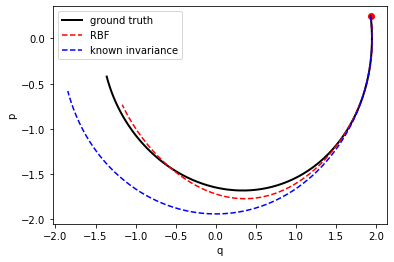

In [34]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
#plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
#plt.savefig("figures/shm_predicted.pdf")

Text(0, 0.5, 'E')

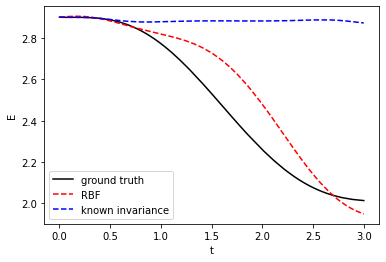

In [35]:

t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="ground truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
#plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/shm_energy.pdf")